# Austin House Prices (EDA and Price Prediction)

## Import Necessary Libraries and Dataset

In [28]:
# Data Manipulation and Visualization Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance as gd
import plotly.express as px
import matplotlib.pyplot as plt
from uszipcode import SearchEngine
import folium
from branca.colormap import linear, LinearColormap

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [29]:
# Import Data and Check Shape (Please replace filepath to suit your needs)
filepath = 'C:/Users/New/Downloads/DS-DC/Austin-Housing-Project/austinHousingData.csv'
austin = pd.read_csv(filepath)
print(f"The Austin Housing Dataset has {austin.shape[0]} rows and {austin.shape[1]} columns.")

The Austin Housing Dataset has 15171 rows and 47 columns.


In [30]:
# Checking Datatypes and Missing Values (Either Command can be Used)
austin.info()
#austin.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zpid                        15171 non-null  int64  
 1   city                        15171 non-null  object 
 2   streetAddress               15171 non-null  object 
 3   zipcode                     15171 non-null  int64  
 4   description                 15169 non-null  object 
 5   latitude                    15171 non-null  float64
 6   longitude                   15171 non-null  float64
 7   propertyTaxRate             15171 non-null  float64
 8   garageSpaces                15171 non-null  int64  
 9   hasAssociation              15171 non-null  bool   
 10  hasCooling                  15171 non-null  bool   
 11  hasGarage                   15171 non-null  bool   
 12  hasHeating                  15171 non-null  bool   
 13  hasSpa                      151

## Clean and Preprocess Dataset Target and Features

In [31]:
# Create Bit Functions for Data Cleaner Function
def city_func(element):
    '''
    This function transforms the city column into Austin or Surrounding Areas
    '''
    if element  == 'austin':
        return 'Austin'
    else:
        return 'Surrounding Areas'

def home_func(element):
    '''
    This function transforms the city column into Austin or Surrounding Areas
    '''
    if element  == 'Single Family':
        return 'Single Family'
    else:
        return 'Non-Single Family'
    
def source_func(element):
    '''
    This function transforms the elements of the price source column into Realtors, 
    Agents or others
    '''
    if element  == 'Agent Provided':
        return 'Agent'
    elif element == 'Broker Provided':
        return 'Broker'       
    else:
        return 'Other Sources'

def uni_price(x):
    '''
    This function transforms 2018, 2019, 2020 amd 2021 prces into 2023 prices, to make
    the prices in the dataset uniform
    '''
    if x == 2018:
        return 1.21
    elif x == 2019:
        return 1.19
    elif x == 2020:
        return 1.18
    else:
        return 1.12

# Create Dataset Cleaner Function
def data_cleaner(df):
    '''
    This function cleans up the Austin Housing Dataset 
    '''
    # Transform zipcode from Int to Object
    df['zipcode'] = df['zipcode'].astype('object')
    
    # Transform yearBuilt to ageofHouse (drop yearBuilt)
    df["ageofHouse"] = 2023 - df["yearBuilt"] 
    
    # Transform the Latest_salemonth Column to Season Column 
    season = {1: 'Winter', 2: 'Winter', 3 : 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}
    df['season'] = df['latest_salemonth'].map(season) 

    # Transform latest_salemonth from Int to Object
    month = {1: 'January', 2: 'February', 3 : 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
    df['salemonth'] = df['latest_salemonth'].map(month)
    
    # Transform City Column in Data into Austin or Surrounding Areas Using city_func
    df['city'] = df['city'].apply(city_func)
    
    # Transform Price Source Column into Agent/Brokers/Others using source_func
    df['latestPriceSource'] = df['latestPriceSource'].apply(source_func)
     
    # Transform the Home Type Column (Single Family or Non-Single Family Homes)
    austin['homeType'] = austin['homeType'].apply(home_func)
    
    # Apply the uni_price function make Prices Uniform
    df['adjustment'] = df['latest_saleyear'].apply(uni_price)
    df['price'] = df['adjustment'] * df['latestPrice']
    
    # Check for House Distance From Airport and City Center
    downtown_austin = (30.266666, -97.733330)
    airport_austin = (30.18999924, -97.668663992)
    df["downtown_distance"] = df.apply(lambda x:gd.distance((x["latitude"], x["longitude"]), downtown_austin).miles, axis=1)
    df["airport_distance"] = df.apply(lambda x:gd.distance((x["latitude"], x["longitude"]), airport_austin).miles, axis=1)
         
    df.drop(columns = ['streetAddress','latest_saledate', 'latest_salemonth',
                       'latest_saleyear', 'latestPrice', 'description', 
                       'adjustment', 'yearBuilt', 'homeImage'], inplace = True)
    
    return df

# Clean Dataset with data_cleaner Function
austin = data_cleaner(austin)

In [32]:
print(f"The Cleaned and Pre-processed Austin Housing Dataset has {austin.shape[0]} rows and {austin.shape[1]} columns.")

The Cleaned and Pre-processed Austin Housing Dataset has 15171 rows and 45 columns.


## Check Datatypes and Visualize Distribitions

In [33]:
# Sort the Variables into Separate Lists of the Categorical and Numerical Columns in the Dataset
float_cols = list(austin.select_dtypes(include=['float64']).columns)
int_cols = list(austin.select_dtypes(include=['int64']).columns)
bool_cols = list(austin.select_dtypes(include=['bool']).columns)
cat_cols = list(austin.select_dtypes(include=['object']).columns)

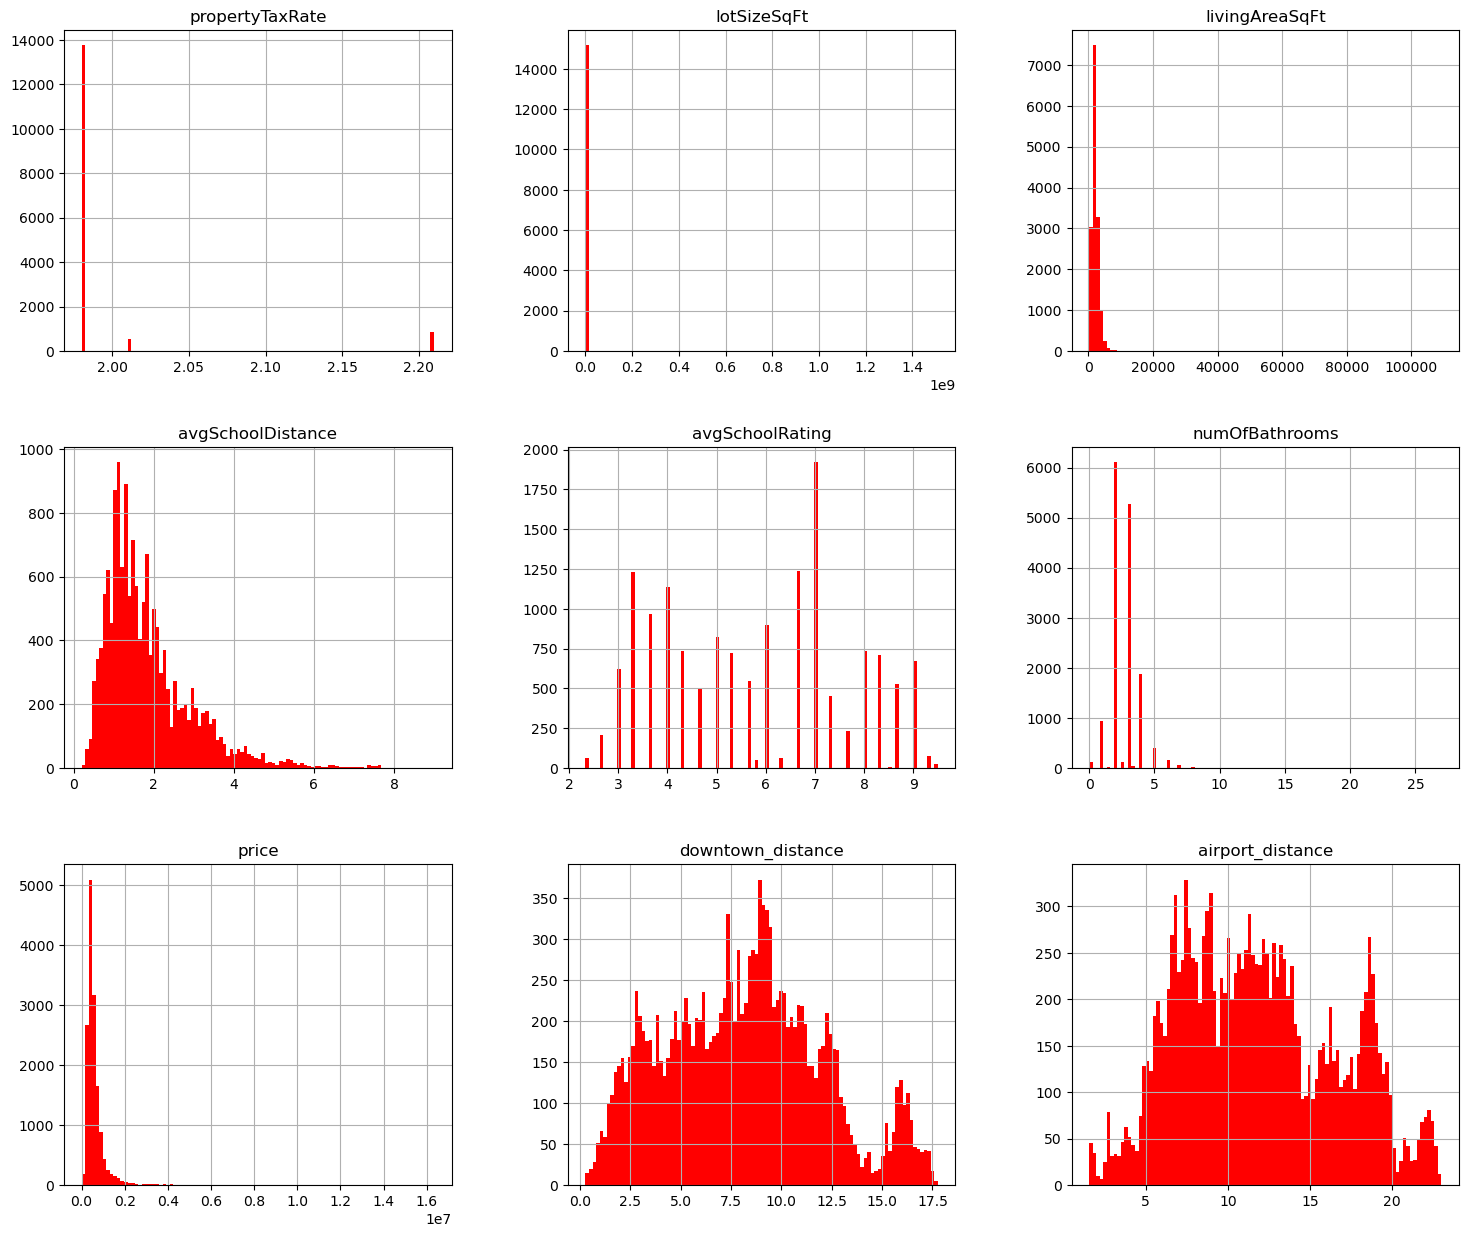

In [34]:
# Visualize All Float Columns in Dataset to Check their Distribution
austin[float_cols].drop(columns = ['latitude', 'longitude']).hist(figsize=(18,15), bins=100, color = 'red');

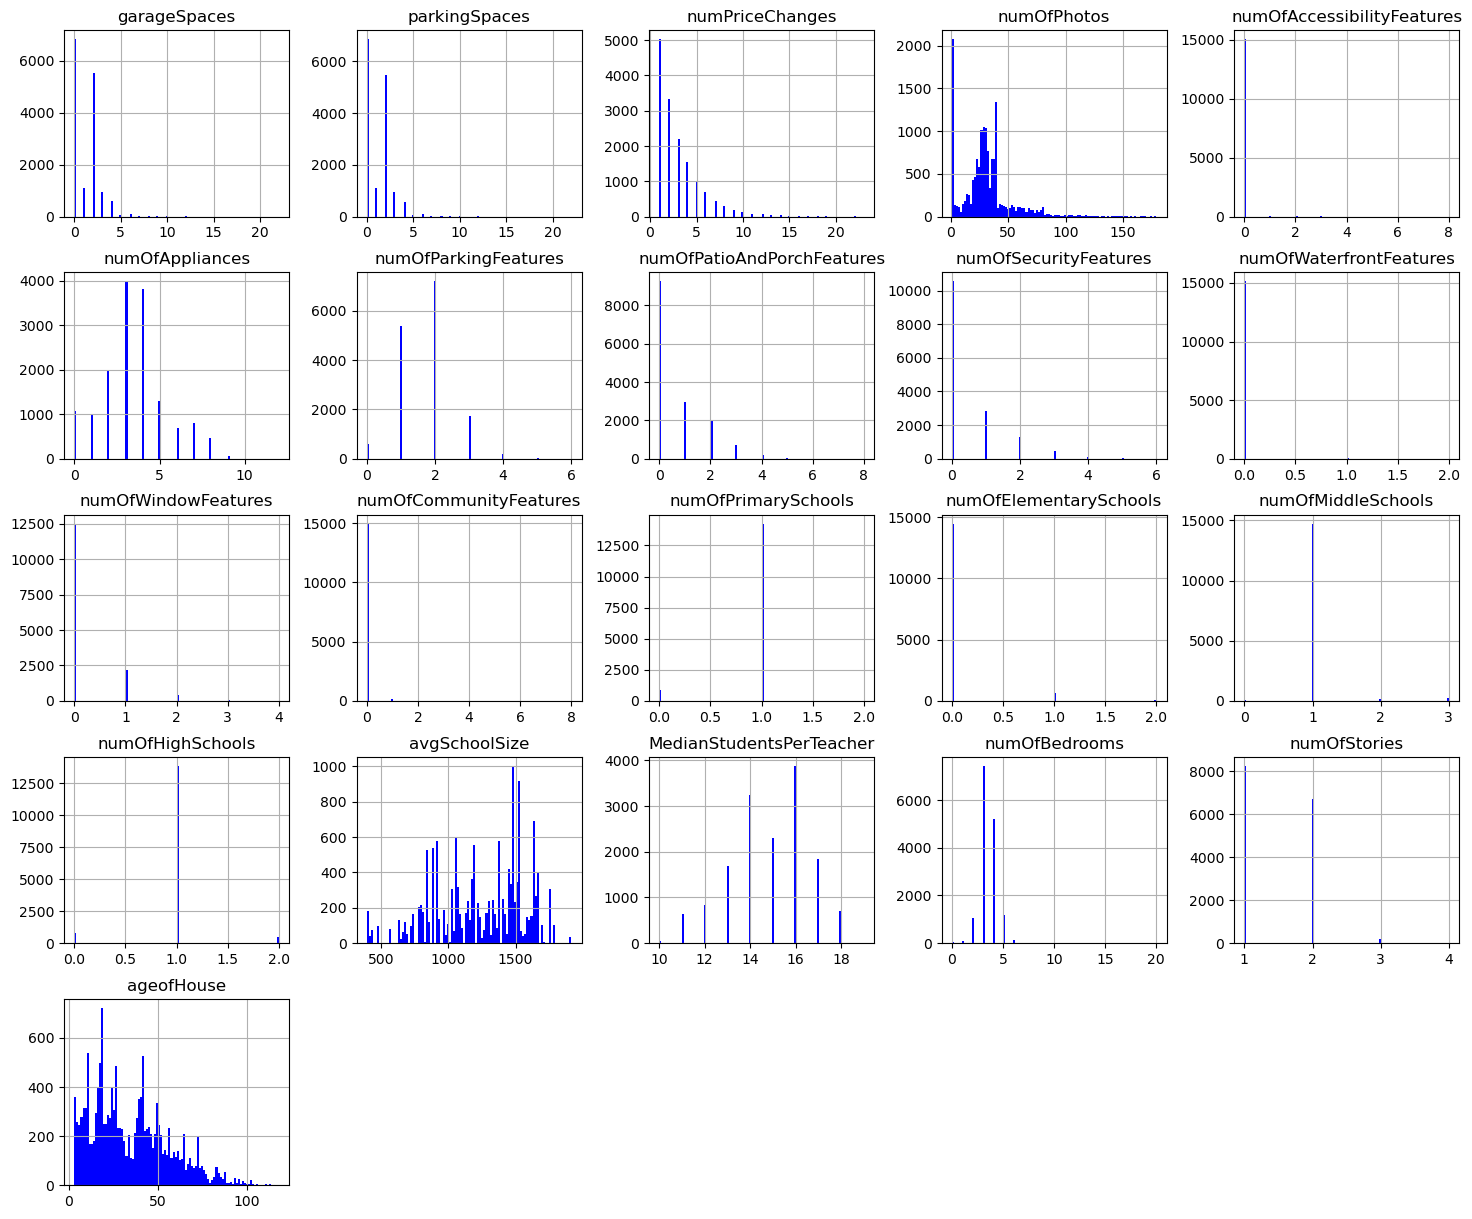

In [35]:
# Visualize All Numeric Columns in Dataset to Check their Distribution
austin[int_cols].drop(columns = ['zpid']).hist(figsize=(18,15), bins=100, color = 'blue');

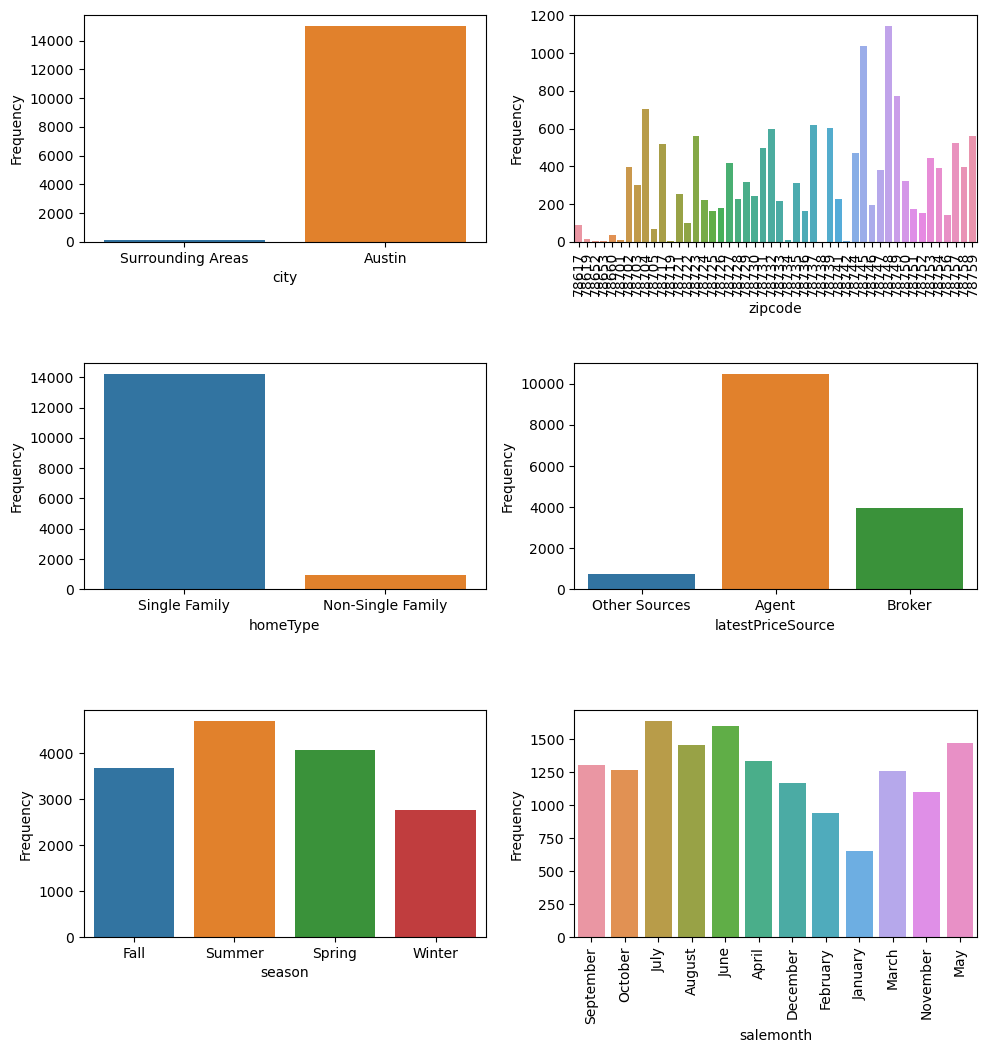

In [36]:
# Use Countplots to View the Distribution of the Categorical Variables
plt.figure(figsize=(10, 20))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(6, 2, i)
    sns.countplot(data=austin, x=col)
    plt.ylabel('Frequency')
    if col in ['zipcode', 'salemonth']:
        plt.xticks(rotation=90)
    else:
        plt.xticks()

plt.tight_layout()
plt.show()

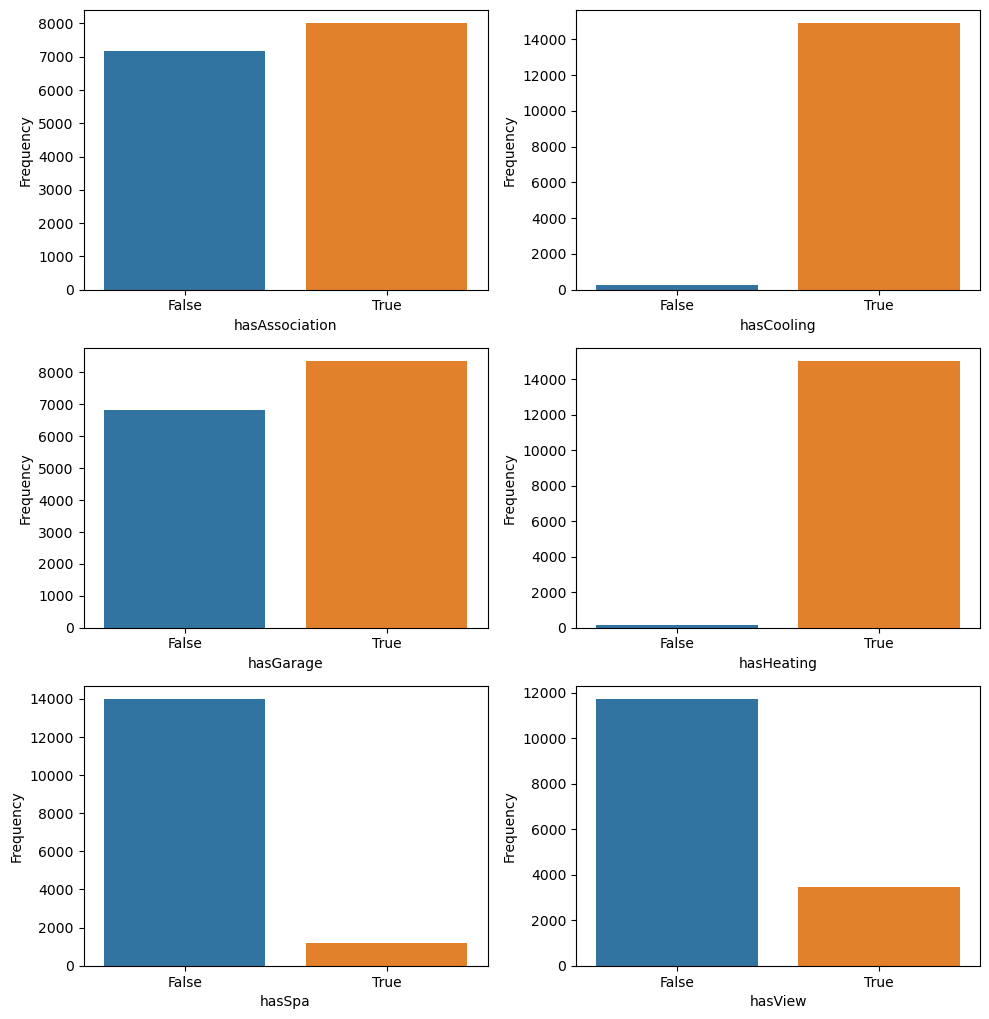

In [37]:
# Use Countplots to View the Distribution of the Boolean Variables in the Dataset
plt.figure(figsize=(10, 20))
for i, col in enumerate(bool_cols, 1):
    plt.subplot(6, 2, i)
    sns.countplot(data=austin, x=col)
    plt.ylabel('Frequency')
    plt.xticks()

plt.tight_layout()
plt.show()

## Data Visualizations And Insights for Stakeholders

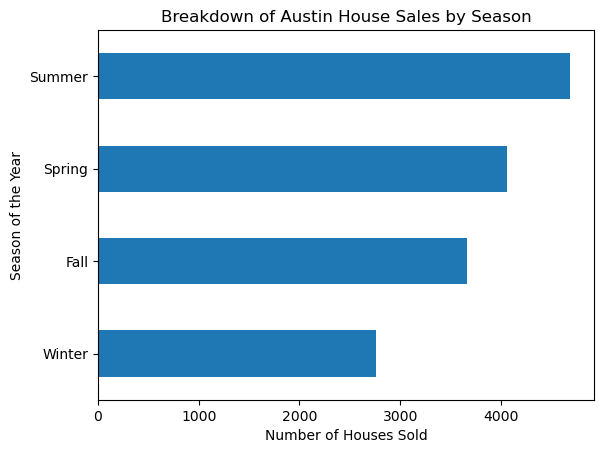

In [38]:
# What Season of the Year Sees the Most and Least House Sales
austin['season'].value_counts(ascending = True).plot(kind = 'barh')
plt.ylabel("Season of the Year")
plt.xlabel("Number of Houses Sold")
plt.title("Breakdown of Austin House Sales by Season");

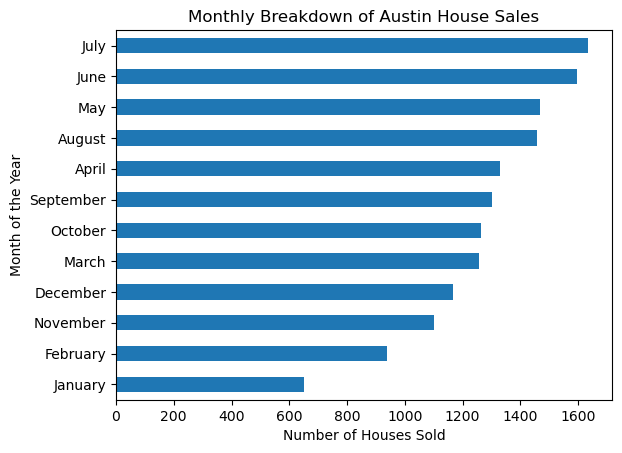

In [39]:
# What Month of the Year Sees the Most and Least House Sales
austin['salemonth'].value_counts(ascending = True).plot(kind = 'barh')
plt.ylabel("Month of the Year")
plt.xlabel("Number of Houses Sold")
plt.title("Monthly Breakdown of Austin House Sales");

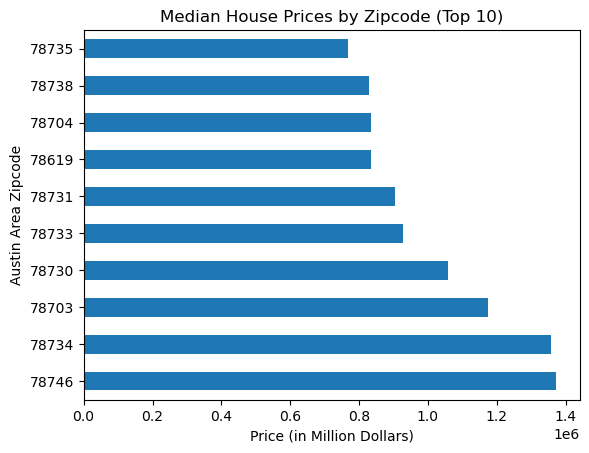

In [40]:
# What Zipcodes have the Highest Median House Prices
median_zipcode = austin.groupby('zipcode')['price'].median().sort_values(ascending=False)
median_zipcode.head(10).plot(kind = 'barh')
plt.ylabel("Austin Area Zipcode")
plt.xlabel("Price (in Million Dollars)")
plt.title("Median House Prices by Zipcode (Top 10)");

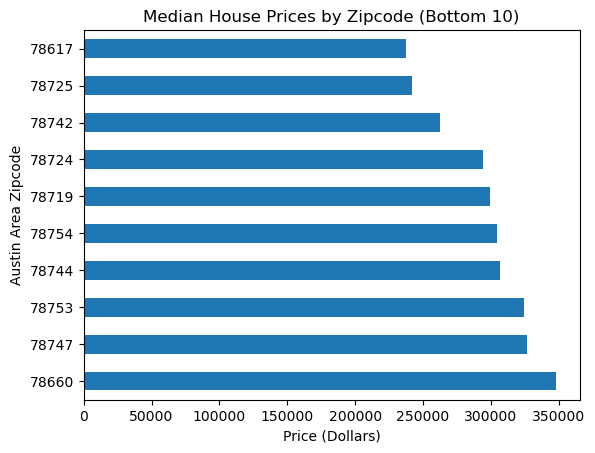

In [41]:
# What Zipcodes have the Lowest Median Prices
median_zipcode = austin.groupby('zipcode')['price'].median().sort_values(ascending=False)
median_zipcode.tail(10).plot(kind = 'barh')
plt.ylabel("Austin Area Zipcode")
plt.xlabel("Price (Dollars)")
plt.title("Median House Prices by Zipcode (Bottom 10)");

In [42]:
# Visualizing the Median House Prices by Zipcode (Using Folium and USZipcodes)
median_prices = austin.groupby("zipcode")["price"].median()
# Instantiante SearchEngine
search = SearchEngine()
zipcodes = [search.by_zipcode(zipcode) for zipcode in median_prices.index]
# Define a color scale
custom_colors = ['#2c7bb6', '#abd9e9', '#fdae61', '#d7191c']
colormap = LinearColormap(custom_colors, vmin=0, vmax=100).scale(median_prices.min(), median_prices.max())
# Create the map
austin_zip_map = folium.Map(location=[30.2672, -97.7431], zoom_start=11, tiles="OpenStreetMap")
# Add circles for each ZIP code
for zipcode in zipcodes:
    center_lat = zipcode.lat
    center_lon = zipcode.lng
    median_price = median_prices.get(float(zipcode.zipcode), 0)
    color = colormap(median_price)
    folium.CircleMarker(
        location=[center_lat, center_lon],
        radius=10,
        fill=True,
        color=color,
        fill_opacity=1.0,
        tooltip="ZIP code: {}<br>Median Price: ${:,.0f}".format(zipcode.zipcode, median_price)
    ).add_to(austin_zip_map)

# Display the map
austin_zip_map

## Price Prediction Modelling